# Training a RL agent

License
```
Copyright 2021 Oscar José Pellicer Valero

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and 
associated documentation files (the "Software"), to deal in the Software without restriction, 
including without limitation the rights to use, copy, modify, merge, publish, distribute, 
sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is 
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or 
substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING 
BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND 
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, 
DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, 
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
```

This file performs the following functions:
 - Build an FMU from a Modelica model using OMPython
 - Set up the BSM1 OpenAI Gym Environment with the FMU at its core
 - Set up an agent to train on the environemnt
 - Train the agent
 - Test the agent
 - See results and plot the evolution of the simulation

In [1]:
# Autoreload modules if code changes
%load_ext autoreload
%autoreload 2

#Import from basic libraries
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pickle
import torch.nn as nn
import gym
from gym.envs.registration import register

#Import from custom libraries
from training import play_episode, ReplayBuffer, plot_vars, combine_results
from agents import QLearningAgent, DeepQLearningAgent, DumbQAgent, EVSarsaAgent
from wrappers import Normalizer, Binarizer, StateHolder

#Import from BSM1 environment
sys.path.append('BSM1Envs')
from bsm1_env import operation_cost

## Exporting the FMU

This step requires an active installation of OpenModelica and OMPython in order to work. This only needs to be redone if the simulation is to be performed in a different OS, or if the model has been modified. Otherwise, if the `EXPORT_FMU` is kept as False, FMU generation is skipped.

In [2]:
#FMU configuration
EXPORT_FMU= False
base_path= '../WasteWaterResearch'
model_name= 'BSM1' #'BSM1.BSM1_ClosedLoop_Sensor_OperatorTest4'

#THe BSM1 environment requires some careful setting up from OpenModelica to export correctly to an FMU
if EXPORT_FMU:
    from utils import Runner
    R= Runner()
    R.run('loadModel(Modelica,{"3.2.3"},true,"",false)')
    R.run('loadFile("%s/WasteWater/package.mo","UTF-8",true,true,false)'%base_path)
    R.run('loadFile("%s/BSM1/package.mo","UTF-8",true,true,false)'%base_path)
    R.run('disableNewInstantiation()')
    R.run('translateModelFMU(%s, version="2.0", fmuType="me")'%model_name)

In [3]:
PATCH_INTERPOLATOR= True
if PATCH_INTERPOLATOR:
    from utils import patch_pyfmi_interpolator
    patch_pyfmi_interpolator()

## Setting up the environment
The environment should be a `.py` file (`bsm1_env.py`) in its own folder (`BSM1Envs`), and the environment's `entry_point` should be edited to also reflect the class inheriting `gym.Env`, which in our case it is: `BSM1Env`, within `bsm1_env.py`

In [4]:
#Time-related configuration
start_time= 14*8 #During the first 30 days the plant stabilizes. This time is simulated during env.reset()
time_step= 1./24./4. #Simulation time step when env.step() is called (days)
max_time= start_time + 365 #Total simulation time (days)
verbose= True
discount_factor_period= 14 #After how many days the reward is multiplied by 0.01
discount_factor= 0.01**(time_step/discount_factor_period)
action_names= ['agent_action']

#Define model and env names
env_name = 'BSM1Env-v0'
entry_point= 'BSM1Envs:BSM1Env'
output_names= ['limiter1.y', 'sensor_class_a1.y']
#output_names+= ['ADsensor_Waste.TSS']

#Delete registered environment in case it exists to avoid errors if this cell is run multiple times
if env_name in gym.envs.registry.env_specs:
    del gym.envs.registry.env_specs[env_name]
    
#Customize simulation options
default_opts= {
    'solver':'Dopri5', #Dopri5, CVode | CVode seems to run slightly faster, but it leaks A TON of memory
    'CVode_options':
        {'discr': 'BDF',
        'iter': 'Newton',
        'atol': 1e-05,
        'rtol': 0.001,
        'maxh': 'Default',
        'external_event_detection': False,
        'linear_solver': 'DENSE', #Must always be set to dense, otherwise Assimulo complains and breaks
        'inith': 0.001,
        'verbosity': 50},
    'Dopri5_options':
        {'atol': 1e-05,
         'rtol': 0.001,
         'inith': 0.0001, #This value has a big impact in the simulation speed
        'verbosity': 50}, #QUIET = 50, WHISPER = 40, NORMAL = 30, LOUD = 20, SCREAM = 10
    'result_handling':'memory', #Keep results in memory rather than saving them into a file
} 

#We will only save the simmulation results associated with some variables, the rest will be discarded
operation_cost_vars= ['tank3.AE', 'tank4.AE', 'tank5.AE',  #Cost variables
                      'ADsensor_Recycle.In.Q', 'ADsensor_Return.In.Q', 'ADsensor_Waste.In.Q',
                      'tank1.ME', 'tank2.ME', 'ADsensor_Waste.TSS', 'ADsensor_Waste.In.Q',
                      'ADsensor_Effluent.In.Q', 'ADsensor_Effluent.In.Snh', 'ADsensor_Effluent.Ntot',
                      'ADsensor_Influent.In.Q', 'ADsensor_Effluent.TSS']
default_opts['filter']= action_names + output_names + operation_cost_vars

#Define the parameters to pass to the initializtion of BSM1Env
parameters= {
         'action_names': action_names, 
         'output_names': output_names,
         'parameters': {}, 
    
         'max_time': max_time, 
         'time_step': time_step, 
         'start_time': start_time,
         'verbose': verbose,
    
         'sim_options': default_opts, 
         'sim_ncp': 30, 
         'path': os.path.abspath('%s.fmu'%model_name),
         'reset': False,
} 

#Register the environment
register(
    id=env_name,
    entry_point= entry_point,
    kwargs= parameters #BSM1Env class parameters as a dictionary
)

#Create an env instance
env= gym.make(env_name)

## Define the agent that we will be using

Legal actions: [1.2 1.5 1.8]
Using agent: EVSarsaAgent2021061613022656


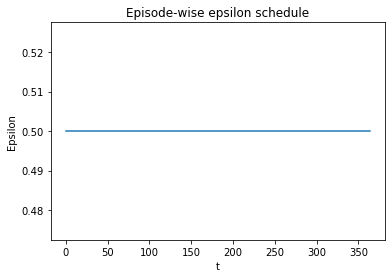

In [5]:
#Agent configuration
AGENT= 'sarsa' #['q', 'deepq', 'sarsa', 'dumb']
EPSILON= 0.5 #0.3, 0.5
EPSILON_DISCOUNT= 0.8 #0.7, 0.8
EPISODES= 1 #10, 20
REWARD_SCALE= 1e-3 / 200
USE_SOFTMAX= True #For use with sarsa
REPLAY_BUFFER= ReplayBuffer(100) #None
BACTH_SIZE= 32
HOLD_N= 1 #If HOLD_N > 0: Use StateHolder wrapper
SCHEDULER_POWER= 0

#Within-epsidoe epsilon scheduling
EPSILON_SCHEDULER= lambda _, t, t_max: EPSILON*(1 - t/t_max)**SCHEDULER_POWER
ts= np.arange(0,365, 1)
plt.plot(ts, EPSILON_SCHEDULER(EPSILON, ts, 365)); 
plt.ylabel('Epsilon'); plt.xlabel('t'); plt.title('Episode-wise epsilon schedule')

#Define the set of discrete actions that the agent can take
#get_legal_actions=lambda state: np.arange(0.8, 2.3, 0.4)
get_legal_actions=lambda state: np.array([1.2, 1.5, 1.8])
print('Legal actions:', get_legal_actions(None))

#Define a network architecture, needed for deep algorithms
state_dim = np.array(env.observation_space.shape) * (HOLD_N + 1)
n_actions= len(get_legal_actions(None))

network = nn.Sequential(
            nn.Linear(state_dim[0], 50), nn.ReLU(),
            #nn.Linear(100, 100),           nn.ReLU(),
            nn.Linear(50, n_actions),
          )

#Choose the agent that we will train with
if AGENT == 'q':
    if HOLD_N > 0:
        env = StateHolder(Binarizer(Normalizer(env)), hold_last_N=HOLD_N)
    else:
        #env= Binarizer( env, valid_values=(np.arange(0., 11., 1.),  np.arange(0.5, 5., 0.5)) )
        env= Binarizer(Normalizer(env))
    agent= QLearningAgent(epsilon=EPSILON, discount=discount_factor,
                          get_legal_actions=get_legal_actions)
elif AGENT == 'deepq': 
    env = StateHolder(Normalizer(env), hold_last_N=HOLD_N) if HOLD_N > 0 else Normalizer(env) 
    agent= DeepQLearningAgent(network, epsilon=EPSILON, discount=discount_factor,
                              get_legal_actions=get_legal_actions, learning_rate=1e-5)
elif AGENT == 'sarsa':
    if HOLD_N > 0:
        env = StateHolder(Binarizer(Normalizer(env), valid_values_auto=np.arange(-2., 2.1, 2/3)))
    else:
        env= Binarizer( env, valid_values=(np.arange(0., 11., 1.),  np.arange(0.5, 5., 0.5)) )
    agent= EVSarsaAgent(epsilon=EPSILON, discount=discount_factor,
                        get_legal_actions=get_legal_actions, use_softmax=USE_SOFTMAX)
elif AGENT == 'dumb':
    agent= DumbQAgent()

print('Using agent:', agent.name)

## Train for a few episodes

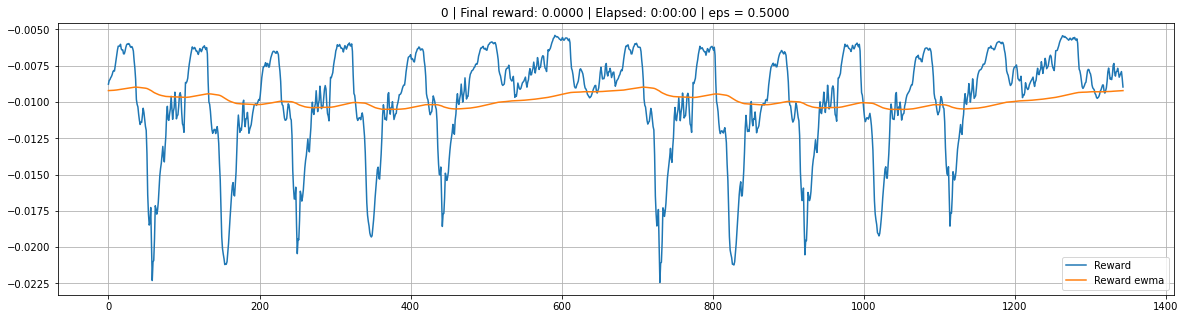

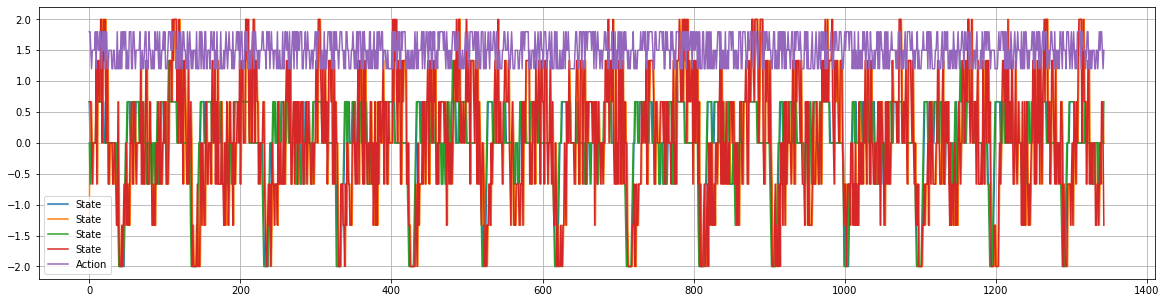

100%|█████████████████████████████████████████████████████████████████████████████| 2313/2313 [00:06<00:00, 347.31it/s]

There was a problem reading some variables. Redoing the simulation without filters may fix it


In [6]:
#Train configuration
TRAIN= True
LOAD_AGENT= False
SAVE_RESULTS= True
RESULTS_NAME= os.path.join('./data', agent.name + '_results')

total_rewards, rewards, states= [], [], []
time0, time1=  datetime.now(), datetime.now()

if LOAD_AGENT:
    agent.load()

if TRAIN:
    for i in range(EPISODES):
        time0= time1
        time1= datetime.now()
        title= '%d | Final reward: %.4f | Elapsed: %s'%(i, total_rewards[-1]/REWARD_SCALE if i!=0 else 0, str(time1-time0))

        total_reward, reward, state, result= play_episode(env, agent, title=title, rb_batch=BACTH_SIZE,
                                                          reward_scale=REWARD_SCALE, replay_buffer=REPLAY_BUFFER,
                                                          epsilon_scheduler=EPSILON_SCHEDULER)
        total_rewards.append(total_reward); rewards.append(reward); states.append(state)
        agent.epsilon*= EPSILON_DISCOUNT

        #Save weights
        agent.save()
        
        #Save results
        if SAVE_RESULTS:
            pickle.dump(result, open(RESULTS_NAME + '_%d.pkl'%i,'wb'))

In [7]:
print('- %s\t| Last training session: %.4f | Config: '%(
         agent.name, -total_rewards[-1]/REWARD_SCALE), BACTH_SIZE, EPSILON, HOLD_N, 
         REPLAY_BUFFER._maxsize if REPLAY_BUFFER is not None else 'no-rb', SCHEDULER_POWER, str(output_names))

- EVSarsaAgent2021061613022656	| Last training session: 2018.9441 | Config:  32 0.5 1 100 0 ['limiter1.y', 'sensor_class_a1.y']


## Plot some of the variables as compared with a dumb agent

Daily average operation cost for agent EVSarsaAgent2021061613022656: 2018.9547 €
Yearly savings: 4493.216160036386


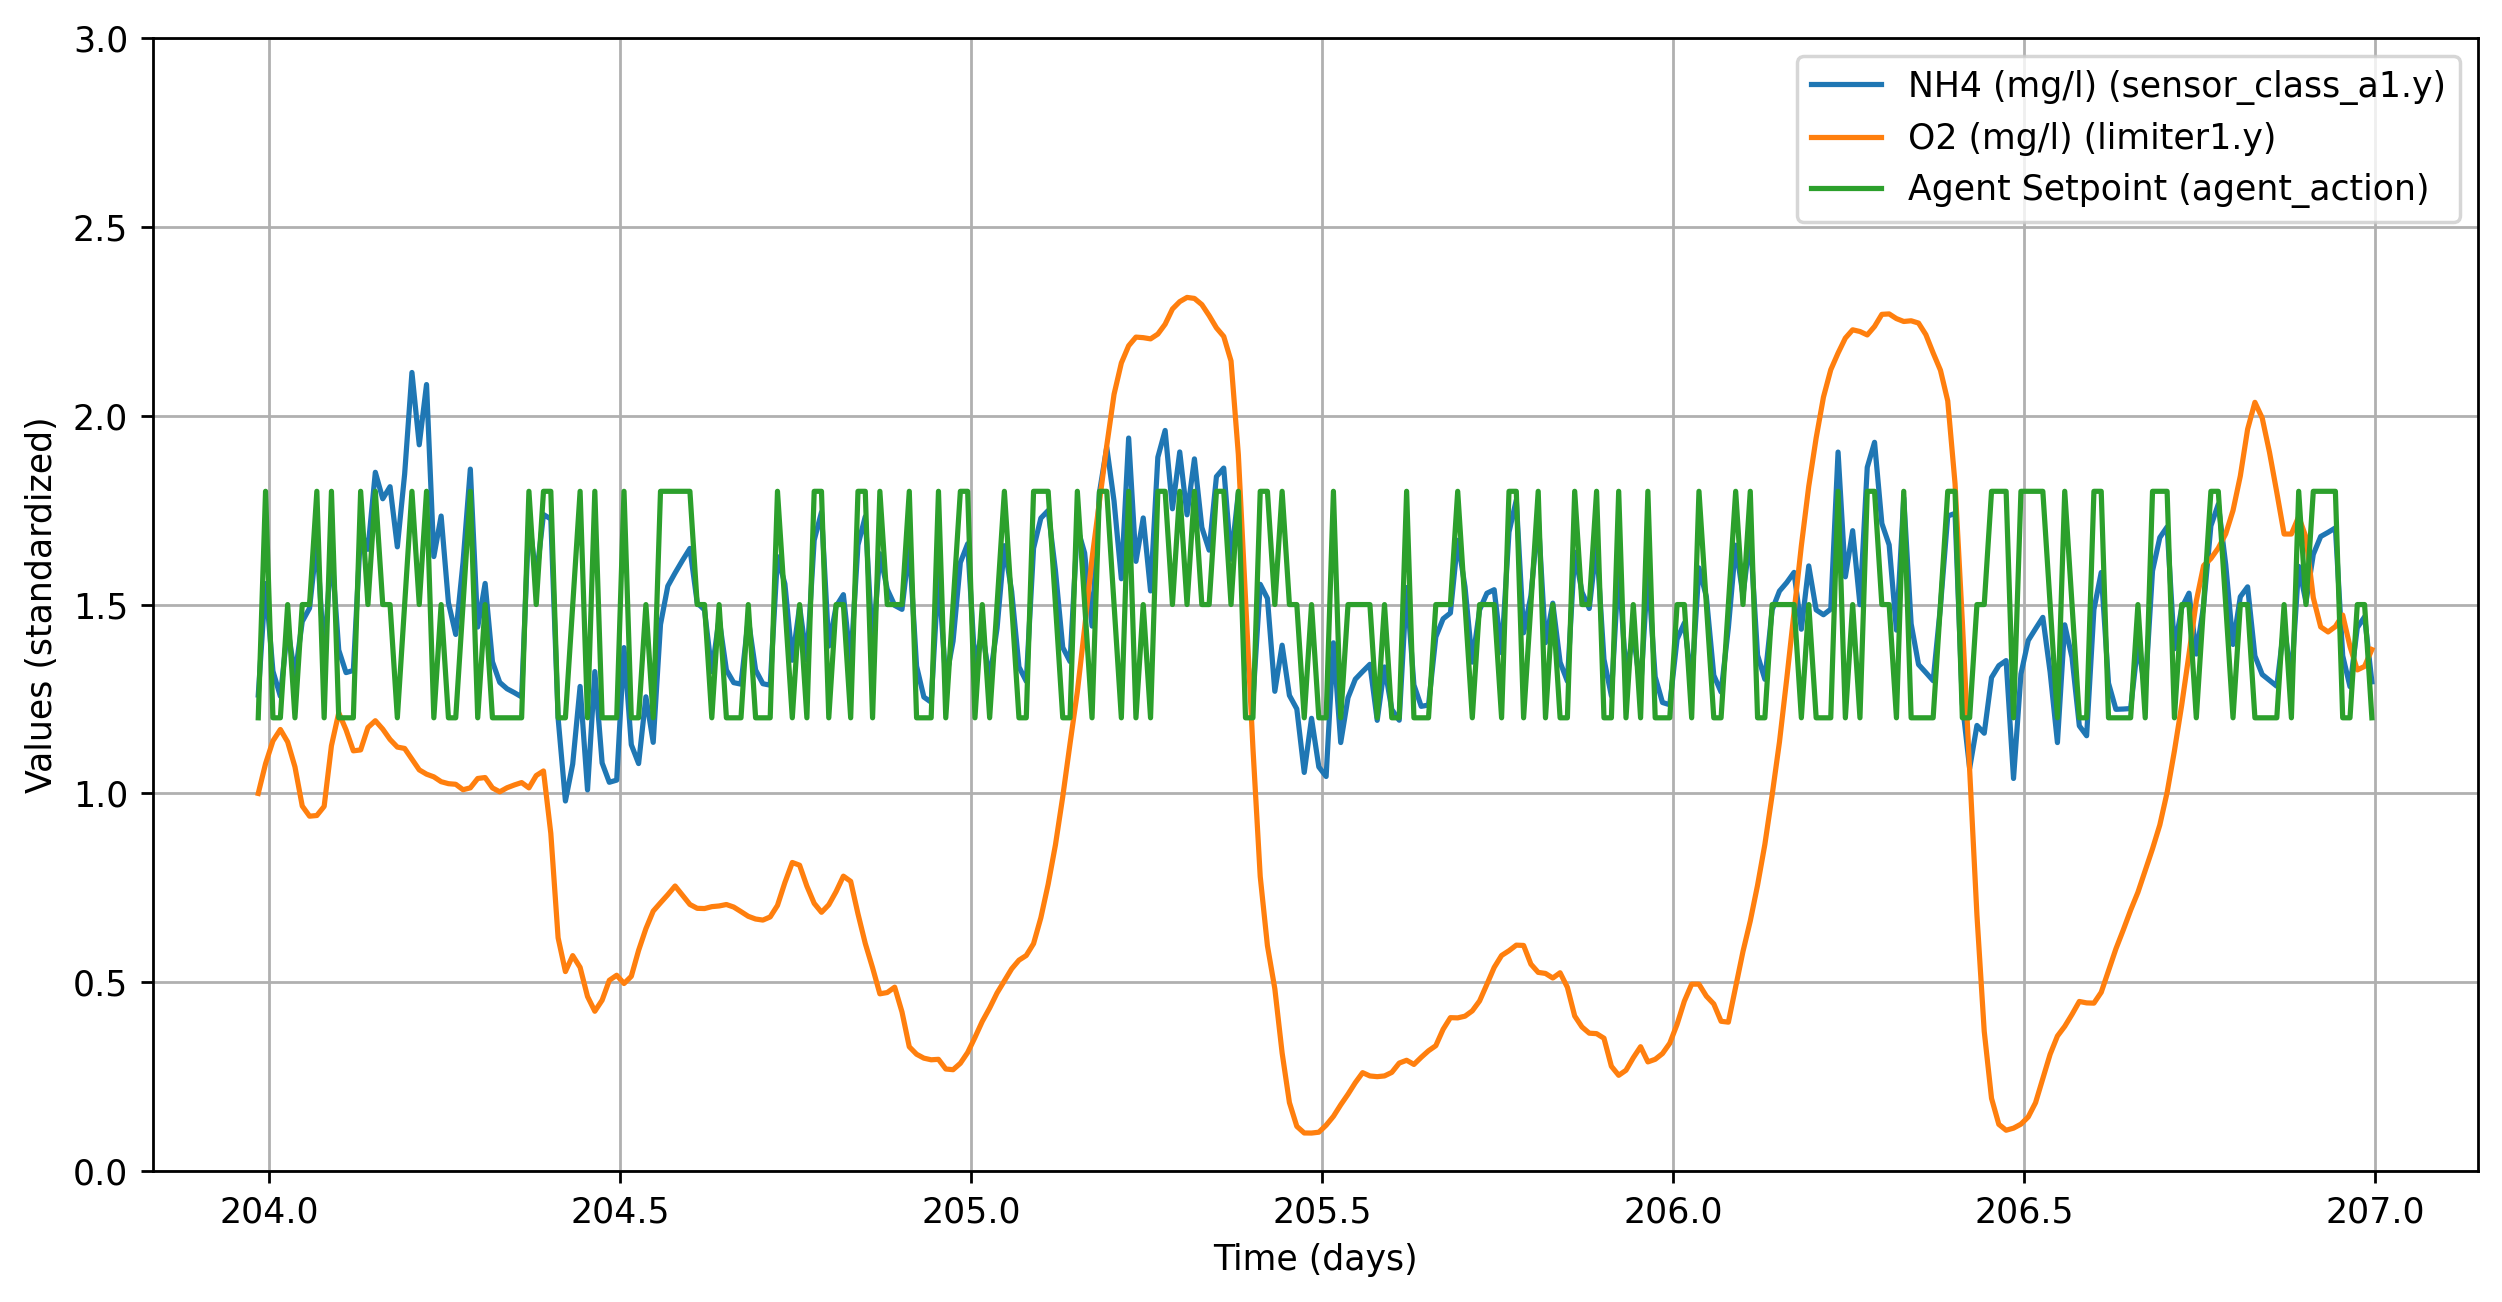

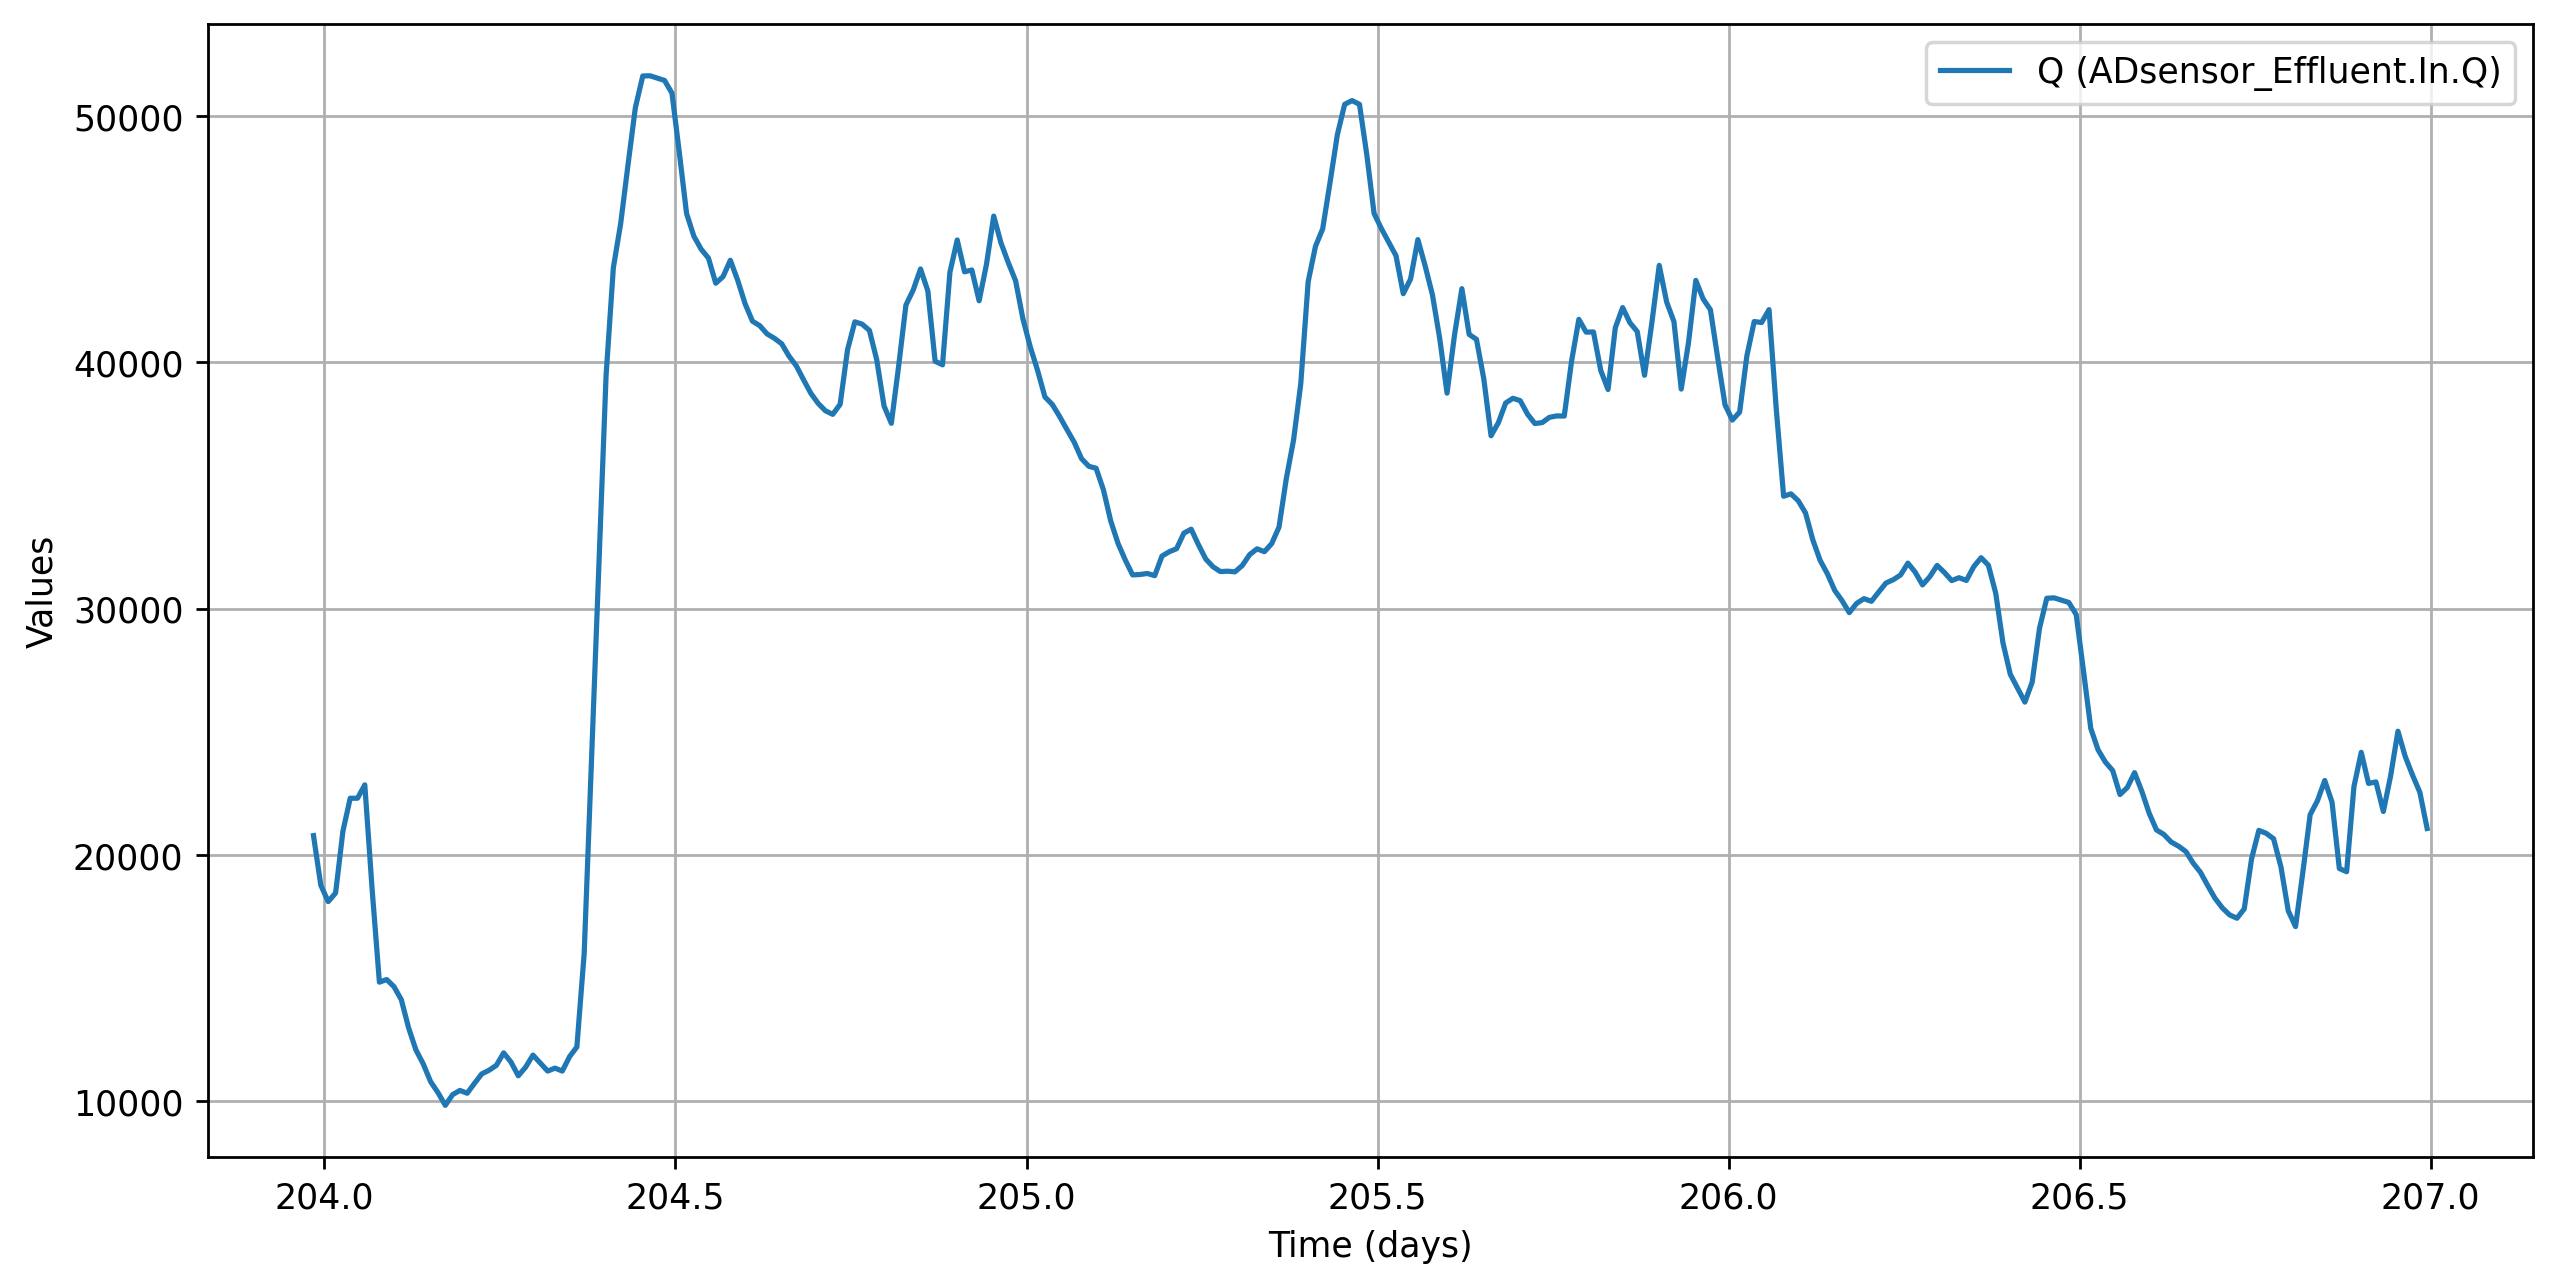

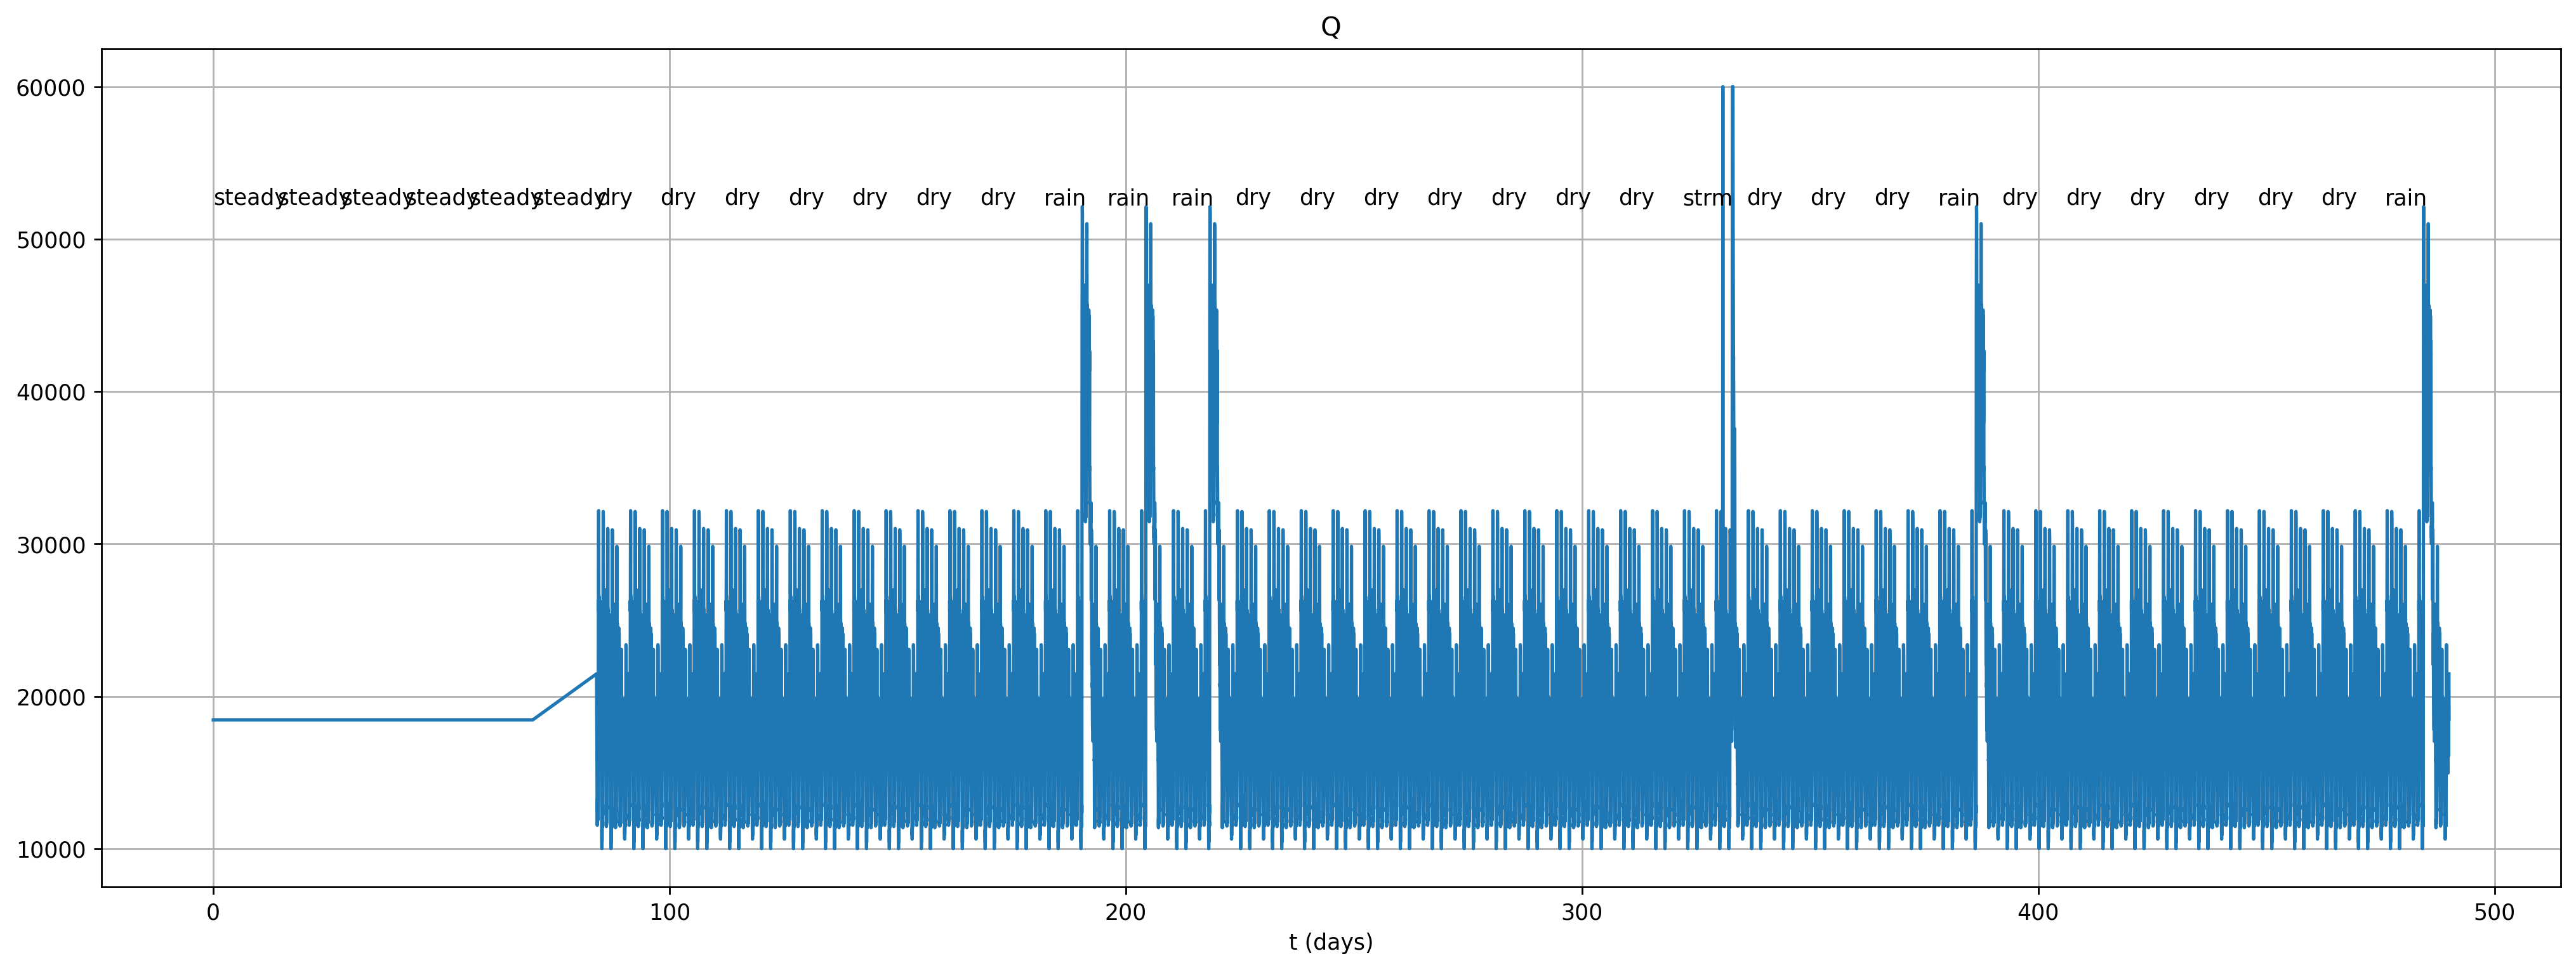

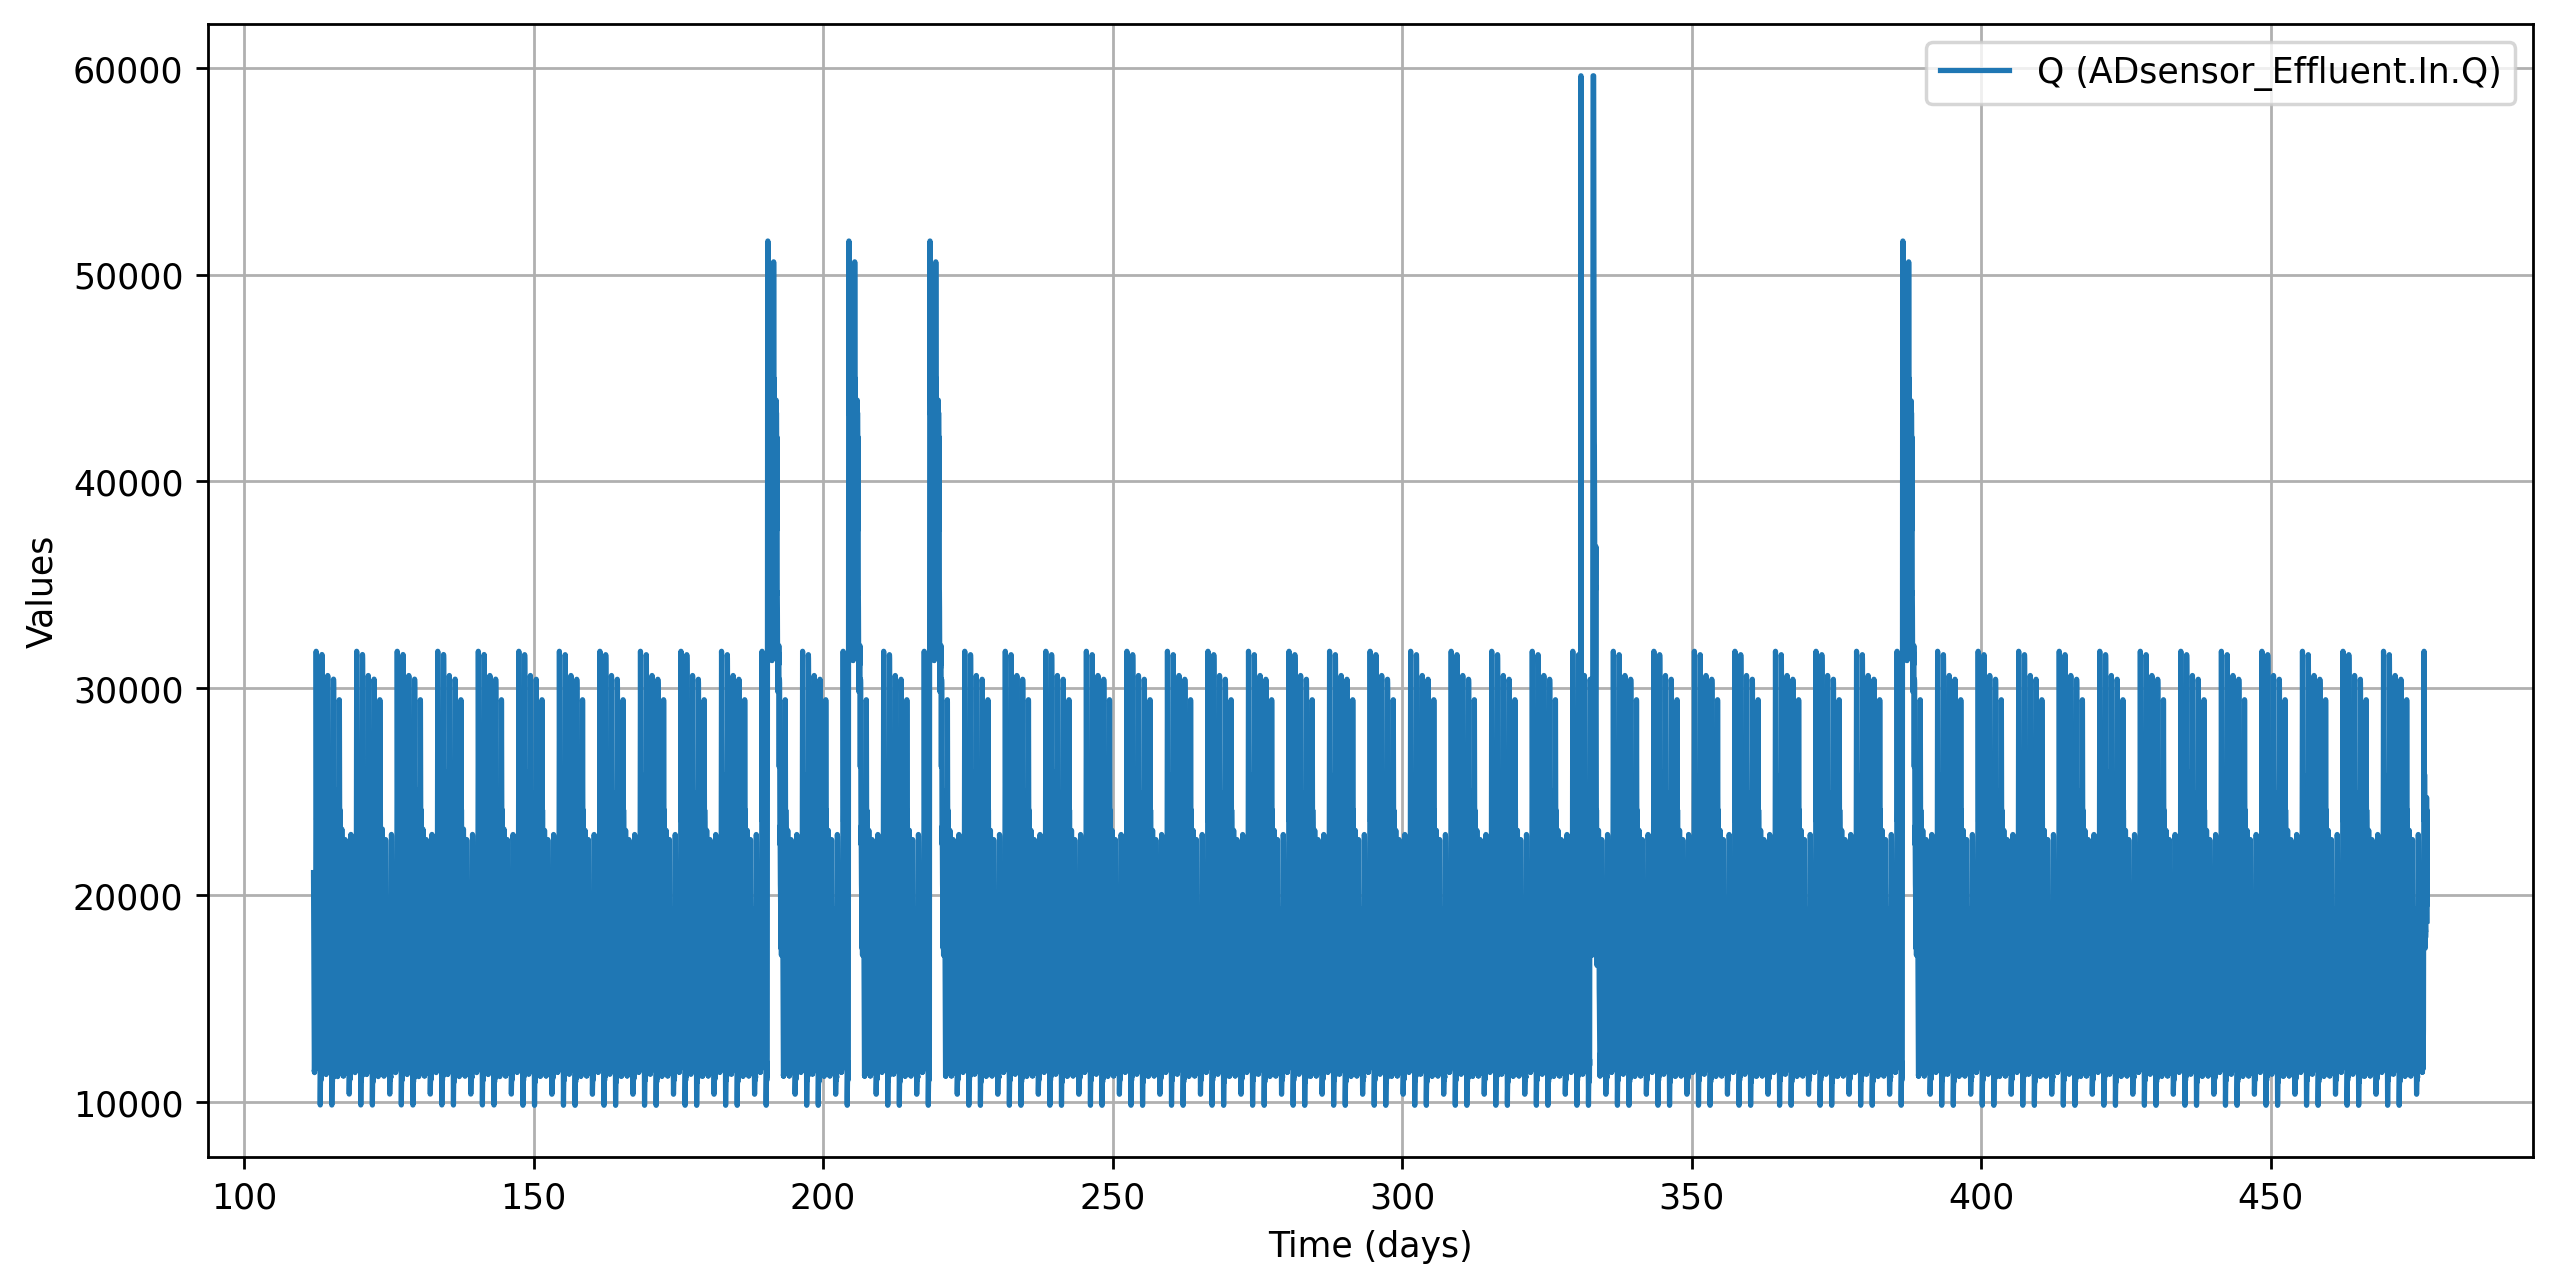

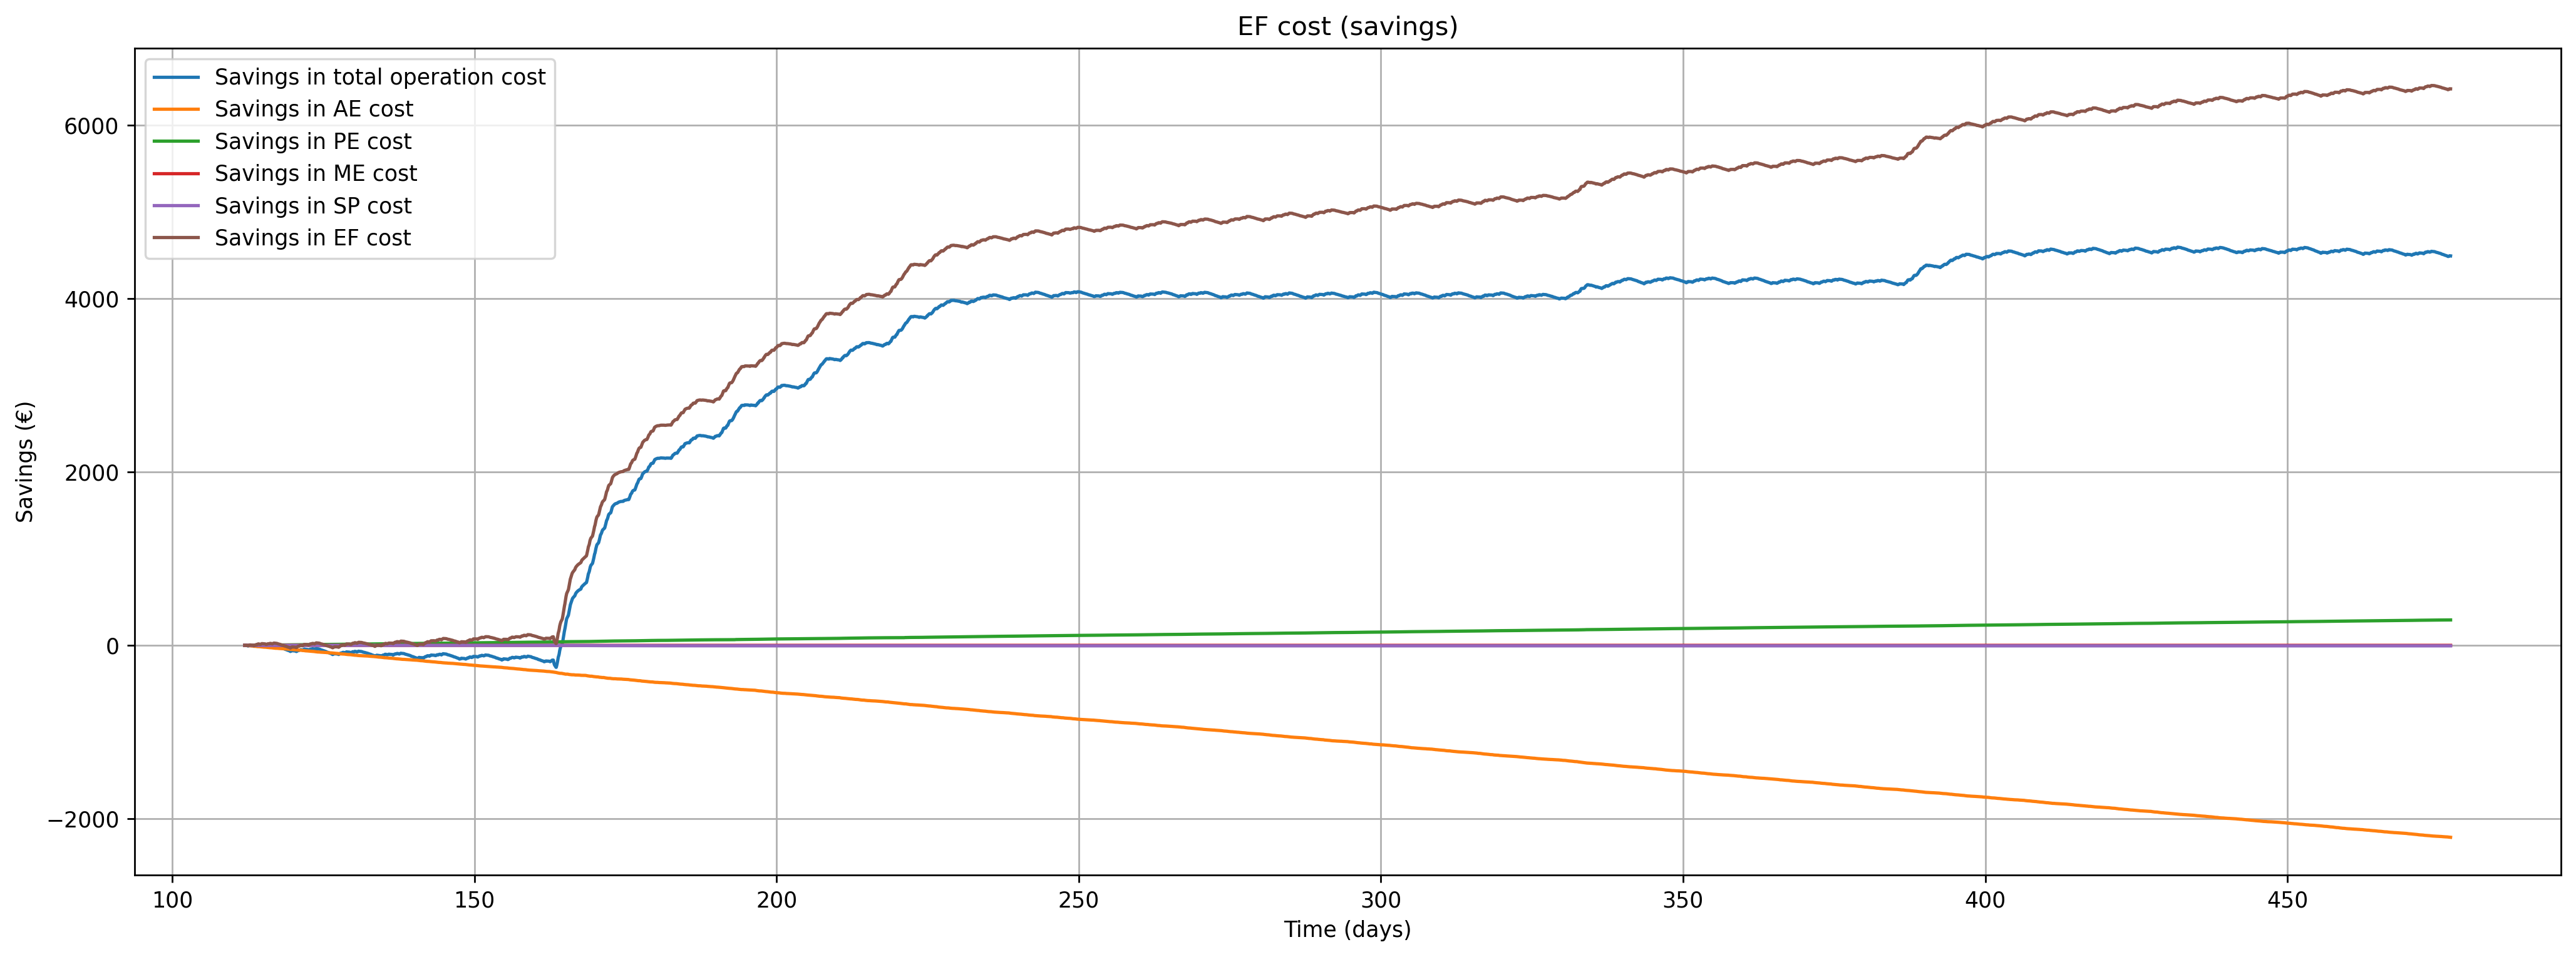

In [8]:
#Plot configuration
DIFF_PLOT= True #Plot differencees wrt dumb
DUMB_RESULTS_NAME=  os.path.join('./data', 'DumbQAgent2021061521454183' + '_results_0.pkl')
RESULTS_NAME= os.path.join('./data', agent.name + '_results_0.pkl')
final_results= pickle.load(open(RESULTS_NAME,'rb'))
final_dumb_results= pickle.load(open(DUMB_RESULTS_NAME,'rb'))
plt.rcParams['figure.dpi'] = 250

#Plot states + actions
t0= 204
t1= t0 + 3
print('Daily average operation cost for agent %s: %.4f €'%(agent.name, operation_cost(final_results, True)))
variables= (['ADsensor_Waste.TSS'] if AGENT == 'deepq' else []) + ['sensor_class_a1.y', 'limiter1.y', 'agent_action'] + []
descriptions=   (['Total suspended solids (mg/L)'] if AGENT == 'deepq' else []) + ['NH4 (mg/l)', 'O2 (mg/l)', 'Agent Setpoint']
plot_vars(final_results, variables, descriptions, t0, t1, ylim=(0,3)); plt.ylabel('Values (standardized)'); plt.grid()
plot_vars(final_results, ['ADsensor_Effluent.In.Q'], ['Q'], t0, t1); plt.grid()

#Plot wheather
from bsm1_env import WWSourceGen
WWSG=WWSourceGen(); WWSG.generate(max_time)
WWSG.plot(10000)
plt.grid()

#Plot cost variables
t0, t1= start_time, max_time
plot_data= operation_cost(final_results)
plot_dumb_data= operation_cost(final_dumb_results)
plot_vars(final_results, ['ADsensor_Effluent.In.Q'], ['Q'], t0, t1); plt.grid()
plt.figure(figsize=(20,7))
for var, description in zip([0, 1, 2, 3, 4, 5, 6], 
                    ['total operation cost', 'total operation cost mothly EWMA', 
                     'AE cost', 'PE cost', 'ME cost', 'SP cost', 'EF cost']):
    first_idx=  np.max( [np.argmin(np.abs(final_results['time'] - t0)) - 1, 0] )
    last_idx=  np.min( [np.argmin(np.abs(final_results['time'] - t1)) + 1, len(final_results['time'])] )
    
    if DIFF_PLOT:
        cummulative= np.cumsum(- plot_data[var][first_idx:last_idx] + plot_dumb_data[var][first_idx:last_idx])*time_step
        if var==0: 
            print('Yearly savings:', cummulative[-1])
        if 'EWMA' in description: continue
        plt.plot(final_results['time'][first_idx:last_idx], cummulative, 
                 label='Savings in ' + description)
        plt.title(description + ' (savings)')
        plt.ylabel('Savings (€)'); plt.xlabel('Time (days)')
    else:
        plt.figure(figsize=(20,7))
        plt.plot(final_results['time'][first_idx:last_idx], plot_data[var][first_idx:last_idx], label='Agent')
        plt.plot(final_results['time'][first_idx:last_idx], plot_dumb_data[var][first_idx:last_idx], label='Constant setpoint')
        plt.title(description)
        plt.ylabel('Cost (€)'); plt.xlabel('Time (days)')
    plt.legend()
plt.grid()